In [1]:
%matplotlib inline
import stripe82
import aplpy
from qso_fit import qso_fit
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl
import matplotlib.image as mpimg
import glob, os
from scipy import interpolate
from astropy.time import Time
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
#from javelin.zylc import get_data
#from javelin.lcmodel import Cont_Model
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


In [2]:
cat_result=fits.open('../ALL_31642_lite.fits')
cat=cat_result[1].data

indall=np.where(cat['SNID'] != '', True,False)

chiqso=[]
chifalse=[]
chi=[]
Class=[]
sigvar=[]
sigqso=[]
signqso=[]
all_name=[]
all_npt=[]
Vstd=[]
ltau=[]
lvar=[]
indagn=indall
for i in range(np.sum(indagn)):
    name=cat['SNID'][indagn][i]
    all_name.append(name)
    file='../data/all_real_lc/des_real_0'+name+'.dat'
    data=np.genfromtxt(file,skip_header =70,usecols=(1,2,3,4,5,6),
                      dtype=(float,'S32','S32',float,float,int),
                      names=['MJD','FLT', 'FIELD', 'FLUXCAL','ERR','flag']) 
    
    host_mag_g=cat['host_g'][indagn][i]
    
    ff=10**((host_mag_g-27.5)/-2.5) # mag to flux for host
    ind=np.where( (data['FLT'] == 'g' ) & ( abs(data['ERR']/data['FLUXCAL']) <0.3) & ((data['FLUXCAL']+ff) >0),True,False)
    mag=-2.5*np.log10((data['FLUXCAL'][ind])+ff)+27.5 
    magerr=-2.5*np.log10((data['FLUXCAL'][ind])+data['ERR'][ind]+ff)+27.5-mag
    mjd=data['MJD'][ind]
    
    
    #save data----------
    Vstd.append(mag.std())
    all_npt.append(len(mjd))
    re=qso_fit(mjd, mag,magerr,filter='g',return_model=True,sys_err=0.0)
    chiqso.append(re['chi2_qso/nu'])
    chifalse.append(re['chi2_qso/nu_NULL'])
    chi.append(re['chi2/nu'])
    Class.append(re['class'])
    sigvar.append(re['signif_vary'])
    sigqso.append(re['signif_qso'])
    signqso.append(re['signif_not_qso'])
    ltau.append(re['ltau'])
    lvar.append(re['lvar'])
    #plot figure-----
    '''
    fig=plt.figure(figsize=(12,12))
    ax=plt.subplot(211)
    plt.style.use('my')
    plt.errorbar(mjd,mag,yerr=magerr,fmt='o',ms=5)
    if len(re['model']) > 0:
        plt.plot(mjd,re['model'],'r-')
        plt.plot(mjd,re['model']+re['dmodel'],'r:')
        plt.plot(mjd,re['model']-re['dmodel'],'r:')
        plt.text(0.7,0.9,'Class: '+re['class'],transform=ax.transAxes,fontsize=16)
    plt.gca().invert_yaxis()
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    #plt.xlim(57000,57300)
    #plt.ylim(26,20)
    plt.text(0.3,0.9,'SNID: '+name,transform=ax.transAxes,fontsize=16)
    plt.text(0.8,0.1,r'$\sigma_{var}$ = '+str(np.round(re['signif_vary'],2))+
             '\n$\sigma_{qso}$ = '+str(np.round(re['signif_qso'],2))+
             '\n$\sigma_{notqso}$ = '+str(np.round(re['signif_not_qso'],2)),
             transform=ax.transAxes,fontsize=16)
    '''
c1 = fits.Column(name='SNID',array=np.array(all_name),format='A7')
c2 = fits.Column(name='chi',array=np.array(chi),format='E')
c3 = fits.Column(name='chiqso',array=np.array(chiqso),format='E')
c4 = fits.Column(name='chifalse',array=np.array(chifalse),format='E')
c5 = fits.Column(name='sig',array=np.array(sigvar),format='E')
c6 = fits.Column(name='sigqso',array=np.array(sigqso),format='E')
c7 = fits.Column(name='signqso',array=np.array(signqso),format='E')
c8 = fits.Column(name='class',array=np.array(Class),format='A10')
c9 = fits.Column(name='ltau',array=np.array(ltau),format='E')
c10= fits.Column(name='lvar',array=np.array(lvar),format='E')
c11 = fits.Column(name='npt',array=np.array(all_npt),format='I')
c12= fits.Column(name='Vstd',array=np.array(Vstd),format='E')
h=fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12])
h.writeto('./ALL_31642_bulter.fits',overwrite=True)


In [192]:

chiqso=[]
chifalse=[]
chi=[]
Class=[]
sigvar=[]
sigqso=[]
signqso=[]
all_name=[]
tau=[]
var=[]
indagn=indsn
#for i in glob.glob('/Users/legolason/study/lightcurve/stripe82/QSO_S82/*'):
#for i in glob.glob('./RRLyr/*.dat'):
for i in glob.glob('./Stripe82Phot/*'):  
    #data=np.genfromtxt(i)
    data=np.genfromtxt(i,delimiter=',')
    if data.shape[0]>0:
        mjd=data[:,-4]
        mag=data[:,10]
        magerr=data[:,11]
        #mjd=data[:,6]
        #mag=data[:,7]
        #magerr=data[:,8]
        ind=np.where((mag>0) & (magerr <0.03) ,True,False)
        #plt.errorbar(mjd,mag,yerr=magerr)

        if np.sum(ind) > 50:
            all_name.append(i[-7:-1])
            re=qso_fit(mjd[ind], mag[ind],magerr[ind],filter='g')

            chiqso.append(re['chi2_qso/nu'])
            chifalse.append(re['chi2_qso/nu_NULL'])
            chi.append(re['chi2/nu'])
            Class.append(re['class'])
            sigvar.append(re['signif_vary'])
            sigqso.append(re['signif_qso'])
            signqso.append(re['signif_not_qso'])

        
c1 = fits.Column(name='ID',array=np.array(all_name),format='A7')
c2 = fits.Column(name='chi',array=np.array(chi),format='E')
c3 = fits.Column(name='chiqso',array=np.array(chiqso),format='E')
c4 = fits.Column(name='chifalse',array=np.array(chifalse),format='E')
c5 = fits.Column(name='sig',array=np.array(sigvar),format='E')
c6 = fits.Column(name='sigqso',array=np.array(sigqso),format='E')
c7 = fits.Column(name='signqso',array=np.array(signqso),format='E')
c8 = fits.Column(name='class',array=np.array(Class),format='A7')


h=fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8])
#h.writeto('./ALL_stripe82.fits',overwrite=True)
#h.writeto('./ALL_stripe82_RRlyr.fits',overwrite=True)
h.writeto('./ALL_stripe82_star.fits',overwrite=True)

198 354
403 670 142 35
True positive: 0.938226299694
False posiive:


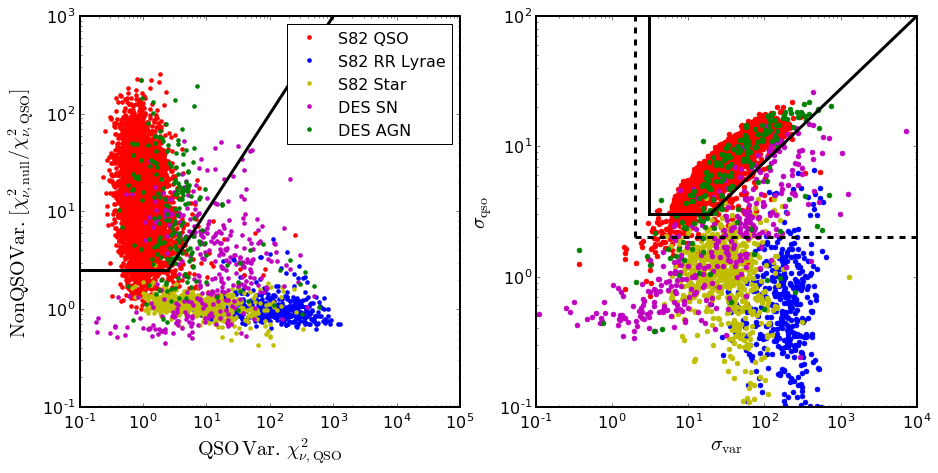

In [54]:
qso=fits.open('./ALL_stripe82.fits')
star=fits.open('./ALL_stripe82_RRlyr.fits')
va=fits.open('./ALL_31642_lite_bulter.fits')
ss=fits.open('./ALL_stripe82_star.fits')

q=qso[1].data
s=star[1].data # RR star
v=va[1].data
s1=ss[1].data

#agn=np.where(v['oztype'] > '-1', True, False)
agn=np.where( ((v['oztype'] == 'AGN_monitoring') | (v['oztype'] == 'AGN_reverberation')) & (v['npt'] >= 10) ,True,False)
sn=np.where(v['sntype']==1,True,False)
print np.sum(agn),np.sum(sn)
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.style.use('my')
n=8
plt.loglog(q['chiqso'],q['chifalse']/q['chiqso'],'r.',markersize=n,label='S82 QSO')
plt.loglog(s['chiqso'],s['chifalse']/s['chiqso'],'b.',markersize=n,label='S82 RR Lyrae')
plt.loglog(s1['chiqso'],s1['chifalse']/s1['chiqso'],'y.',markersize=n,label='S82 Star')
plt.loglog(v['chiqso'][sn],v['chifalse'][sn]/v['chiqso'][sn],'m.',markersize=n,label='DES SN')
plt.loglog(v['chiqso'][agn],v['chifalse'][agn]/v['chiqso'][agn],'g.',markersize=n,label='DES AGN')
#plt.loglog(v['chiqso'],v['chifalse']/v['chiqso'],'c.',markersize=2,label='DES ALL')

plt.ylabel(r'$\rm NonQSO Var.\, [\chi^2_{\nu,null}/\chi^2_{\nu,QSO}]$')
plt.xlabel(r'$\rm QSO\, Var.\, \chi^2_{\nu,QSO}$')
x=np.arange(0,2.5,0.01)
plt.plot([0.1,2.5],[2.5,2.5],'k')
x1=np.arange(2.5,1000,1)
plt.plot(x1,x1,'k')
plt.ylim(0.1,1000)
plt.legend(fontsize=16,numpoints=1)
plt.xlim(0.1,1.e5)


plt.subplot(122)
plt.loglog(q['sig'],q['sigqso'],'r.',label='S82 QSO')
plt.loglog(s['sig'],s['sigqso'],'b.',label='S82 RR Lyrae')
plt.loglog(s1['sig'],s1['sigqso'],'y.',label='S82 Star')
plt.loglog(v['sig'][sn],v['sigqso'][sn],'m.',label='DES SN')
plt.loglog(v['sig'][agn],v['sigqso'][agn],'g.',label='DES AGN')
#plt.loglog(v['sig'],v['sigqso'],'c.',label='DES AGN')

plt.ylim(0.1,100)
plt.xlim(0.1,10000)

x=np.arange(0,2.5,0.01)
plt.plot([3,3],[3,100],'k')
plt.plot([3,20],[3,3],'k')
x1=np.arange(10**1.3,10**4,1)
plt.plot(x1,10**(0.56*np.log10(x1)-0.24),'k')  # logy > 0.56logx -0.24

plt.plot([2,2],[2,100],'k--')
plt.plot([2,10000],[2,2],'k--')
plt.xlabel(r'$\rm \sigma_{var} $')
plt.ylabel(r'$\rm \sigma_{qso}$')
#plt.legend(fontsize=16,numpoints=1,loc='best')


inagn=np.where( ((v['oztype'] == 'AGN_monitoring') | (v['oztype'] == 'AGN_reverberation'))& (v['npt']>=10)&
    (v['sigqso'] > 3.) & (v['sig'] > 3.)& ((np.log10(v['sigqso']) > (0.56*np.log10(v['sig'])-0.24)) ), True,False)
insn=np.where( (v['sntype']==1) &(v['sigqso'] > 3.) & (v['sig'] > 3.)& 
                 ((np.log10(v['sigqso']) > (0.56*np.log10(v['sig'])-0.24)) ), True,False)
inrr=np.where((s['sigqso'] > 3.) & (s['sig'] > 3.)& 
              ((np.log10(s['sigqso']) > (0.56*np.log10(s['sig'])-0.24)) ), True,False)
instar=np.where((s1['sigqso'] > 3.) & (s1['sig'] > 3.)& 
                ((np.log10(s1['sigqso']) > (0.56*np.log10(s1['sig'])-0.24)) ), True,False)


print np.sum(~inrr),np.sum(~instar), np.sum(inagn),np.sum(insn)




In [172]:
#download stripe 82 light curves
df=np.genfromtxt('./stripe82calibStars_v2.6.dat',skip_header=41)
import stripe82
ind=np.where(df[:,5] > 25,True,False)

#a = stripe82.Stripe82()
#for i in range(np.sum(ind)):
#    ra=df[ind][i][1]
#    dec=df[ind][i][2]
#    a.q(ra,dec)

data=np.genfromtxt('./Stripe82Phot/sdss_0_22.502644+0.838850.phot',delimiter=',')
mjd=data[:,-4]
mag=data[:,10]
err=data[:,11]
ind=np.where((mjd >0)& (mag > 0) & (err < 0.03),True,False)
plt.errorbar(mjd[ind],mag[ind],yerr=err[ind])

qso_fit(mjd[ind], mag[ind],err[ind],filter='g')

[34.593803] [-4.509953]
-3.6287168759968806


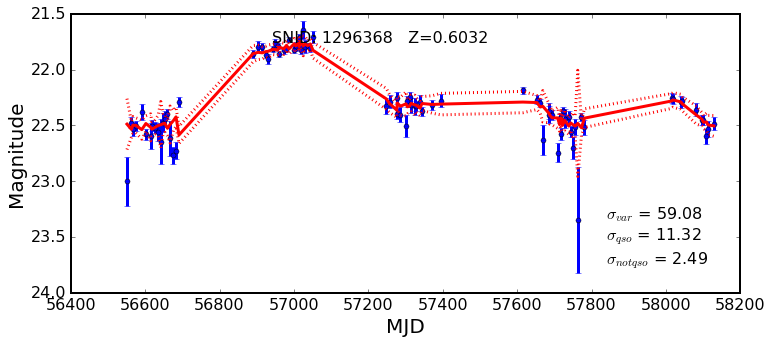

In [58]:
#domo the light curve for single object (corrected 2019)
# plot examples and original flux calibration test for 1279780 (a SN) 
cat_result=fits.open('../ALL_31642_lite.fits')
cat=cat_result[1].data
#agn=fits.open('./ALL_AGN_test.fits')

#print agn[1].data['SNID'][0]

name='1392144'
#name='1247414'
name='1296368'

#name='1279780'# SN for test
idx=np.where(cat['SNID'] == name,True,False)
print cat['ra'][idx],cat['dec'][idx]


file='../data/all_real_lc/des_real_0'+name+'.dat'
data=np.genfromtxt(file,skip_header =70,usecols=(1,2,3,4,5,6),
                  dtype=(float,'S32','S32',float,float,int),
                  names=['MJD','FLT', 'FIELD', 'FLUXCAL','ERR','flag']) 

host_mag_g=cat['host_g'][idx]

ff=10**((host_mag_g-27.5)/-2.5) # mag to flux

ind=np.where( (data['FLT'] == 'g' ) & ( abs(data['ERR']/data['FLUXCAL']) <0.3) & ((data['FLUXCAL']+ff) >0),True,False)


mag=-2.5*np.log10((data['FLUXCAL'][ind])+ff)+27.5
magerr=-2.5*np.log10((data['FLUXCAL'][ind])+data['ERR'][ind]+ff)+27.5-mag
mjd=data['MJD'][ind]

re=qso_fit(mjd, mag,magerr,filter='g',return_model=True)
print re['lvar']

fig=plt.figure(figsize=(12,5))
ax=plt.subplot(111)
plt.style.use('my')
plt.errorbar(mjd,mag,yerr=magerr,fmt='o',ms=5)
plt.plot(mjd,re['model'],'r-')
plt.plot(mjd,re['model']+re['dmodel'],'r:')
plt.plot(mjd,re['model']-re['dmodel'],'r:')

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')
#plt.xlim(57000,57300)
#plt.ylim(26,20)
plt.text(0.3,0.9,'SNID: '+name+'   Z='+str(cat['z_final'][idx][0]),transform=ax.transAxes,fontsize=16)
plt.text(0.8,0.1,r'$\sigma_{var}$ = '+str(np.round(re['signif_vary'],2))+
         '\n$\sigma_{qso}$ = '+str(np.round(re['signif_qso'],2))+
         '\n$\sigma_{notqso}$ = '+str(np.round(re['signif_not_qso'],2)),
         transform=ax.transAxes,fontsize=16)

plt.savefig('../../../Desktop/1.pdf')



./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20121118.fits
90.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20121118.fits
90.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpRQzWmt [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmprY0nnn [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpYs_4Bd [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -1.750e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.399e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -9.214e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.602e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -7.877e+01 (auto) [aplpy.rgb]
INFO: vmax =  1.136e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20121202.fits
175.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20130204.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20130204.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpBaBD5F [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpf5C2sN [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpG2ZINS [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -9.098e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.077e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -6.998e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.165e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.355e+01 (auto) [aplpy.rgb]
INFO: vmax =  6.896e+01 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20130829.fits
10.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20131009.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20131009.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpsrW5R8 [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpA7KIIn [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpswYk3L [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -1.117e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.943e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -7.579e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.558e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.314e+01 (auto) [aplpy.rgb]
INFO: vmax =  1.163e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20131013.fits
10.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20131208.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20131208.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpnaHaGS [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpDT4bDV [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmp4LiQ0I [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -9.232e+01 (auto) [aplpy.rgb]
INFO: vmax =  4.002e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -8.176e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.296e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -3.303e+02 (auto) [aplpy.rgb]
INFO: vmax =  3.449e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20131218.fits
10.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20140205.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20140205.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpVOOp4D [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpXqLnXk [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpdc4dAB [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -2.290e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.547e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -2.412e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.261e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -1.577e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.252e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20140820.fits
175.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-01031

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20141012.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20141012.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpTentjs [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmp3MzXI0 [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmppUUJpA [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -1.284e+02 (auto) [aplpy.rgb]
INFO: vmax =  3.114e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -1.704e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.395e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -1.188e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.660e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20141018.fits
175.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-01031

INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpP0ADqb [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpNuQEm7 [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpyfiULO [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -1.210e+02 (auto) [aplpy.rgb]
INFO: vmax =  3.279e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -1.111e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.937e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.402e+02 (auto) [aplpy.rgb]
INFO: vmax =  4.675e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20141211.fits
175.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20141211.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20141211.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylv

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20150910.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20150910.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpEeRMkn [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpwl2hjV [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpsDEgts [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -7.396e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.489e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -6.050e+01 (auto) [aplpy.rgb]
INFO: vmax =  1.184e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -3.581e+01 (auto) [aplpy.rgb]
INFO: vmax =  3.191e+01 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20150911.fits
175.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-01031

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20151029.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20151029.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpaLTjaS [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmppdwsK5 [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpaVQCQJ [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -7.090e+02 (auto) [aplpy.rgb]
INFO: vmax =  4.329e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -1.019e+03 (auto) [aplpy.rgb]
INFO: vmax =  6.433e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.004e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.646e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20151102.fits
10.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316

./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_r_20160101.fits
150.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_i_20160101.fits
200.0
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpLUQuAz [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmpuGwnU4 [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/17/m3grrd7d0757ylvy9_tynwrm0000gn/T/tmp2qwvEg [montage_wrapper.wrappers]
INFO: Red: [aplpy.rgb]
INFO: vmin = -9.502e+01 (auto) [aplpy.rgb]
INFO: vmax =  4.221e+02 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -7.190e+01 (auto) [aplpy.rgb]
INFO: vmax =  2.531e+02 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -2.033e+02 (auto) [aplpy.rgb]
INFO: vmax =  2.394e+02 (auto) [aplpy.rgb]
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316.8_g_20160108.fits
10.0
./gif_figure/thumbs_DESJ_024246.1-010316.8/DESJ024246.1-010316

(-0.5, 78.5, 78.5, -0.5)

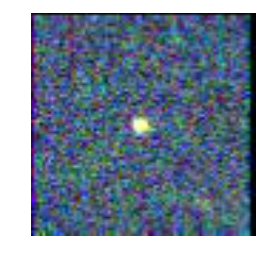

In [173]:
#produce the RGB figure first for single object of each epoch

#ra=41.80371
#dec=-1.185075

ra=40.692028
dec=-1.054666

for path in glob.glob('./gif_figure/thumbs_DESJ_024246.1-010316.8/*_g_*.fits'):
    for i in ['g','r','i']:
        if i=='r':
            path=path.replace('_g_','_r_')
        if i=='i':
            path=path.replace('_r_','_i_')
        try:
            hdu=fits.open(path)[0]
        except:
            continue
        print path
        data=hdu.data
        factor=np.ones_like(data)*hdu.header['exptime']/100.
        print hdu.header['exptime']
        data=data/factor
        
        
        wcs = WCS(hdu.header)

        position = SkyCoord(ra,dec, frame='icrs',unit="deg")
        size = u.Quantity((20, 20), u.arcsec)
        cutout = Cutout2D(data, position, size,wcs=wcs)


        hdu.header.update(cutout.wcs.to_header())
        hdu.data = cutout.data
        hdu.writeto('./gif_figure/3color/'+i+'_cut.fits', overwrite=True)
    try:
        aplpy.make_rgb_cube(['./gif_figure/3color/i_cut.fits',
                            './gif_figure/3color/r_cut.fits',
                            './gif_figure/3color/g_cut.fits'], 
                            './gif_figure/3color/RGB_cube.fits')
        aplpy.make_rgb_image('./gif_figure/3color/RGB_cube.fits',
                             './gif_figure/3color/'+path[-13:-5]+'_RGB.jpg')
    except:
        continue
        

plt.imshow(mpimg.imread('./gif_figure/3color/'+path[-13:-5]+'_RGB.jpg'))
plt.axis('off')


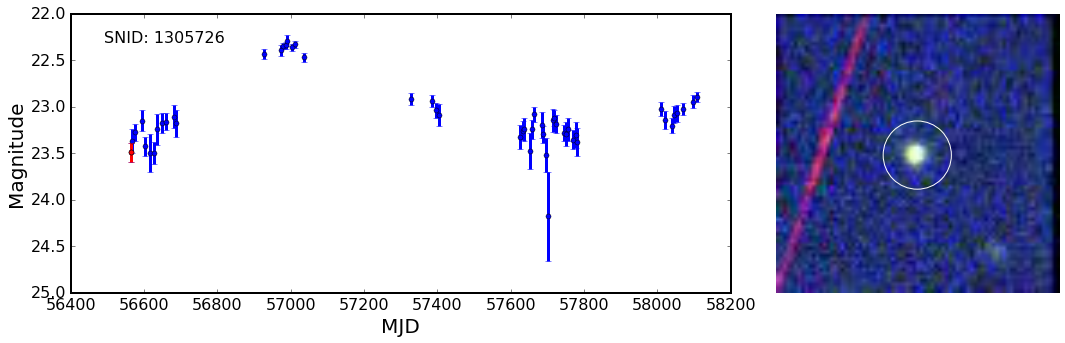

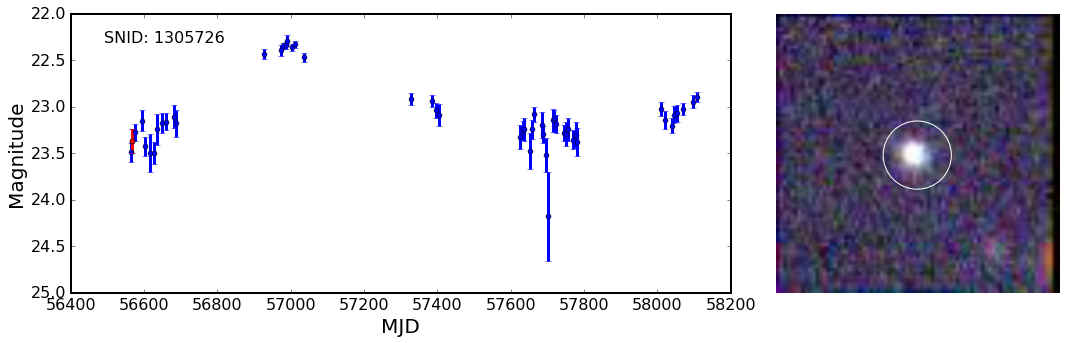

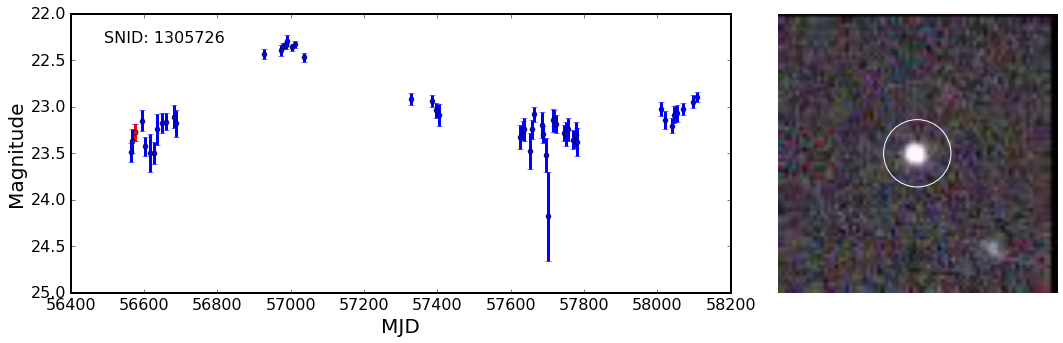

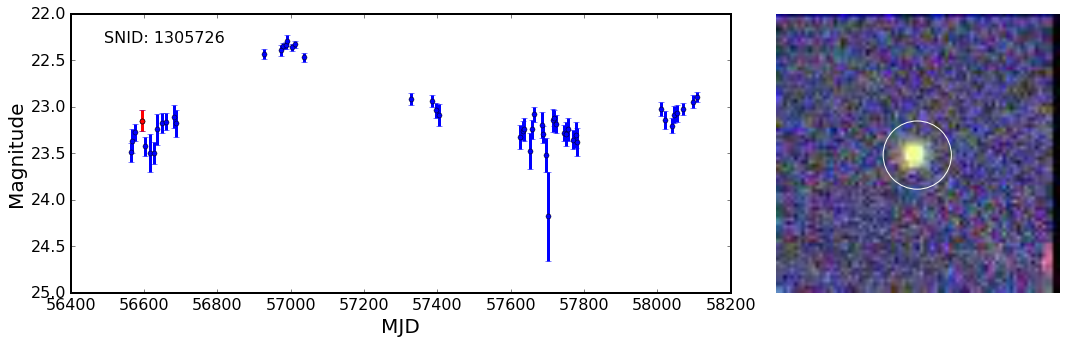

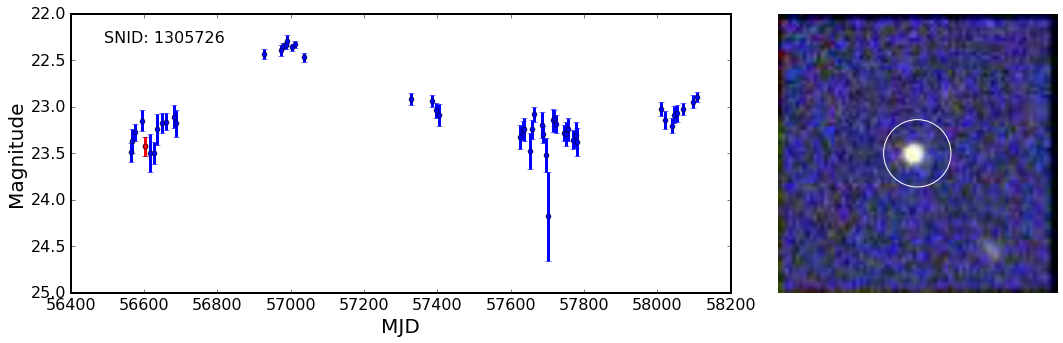

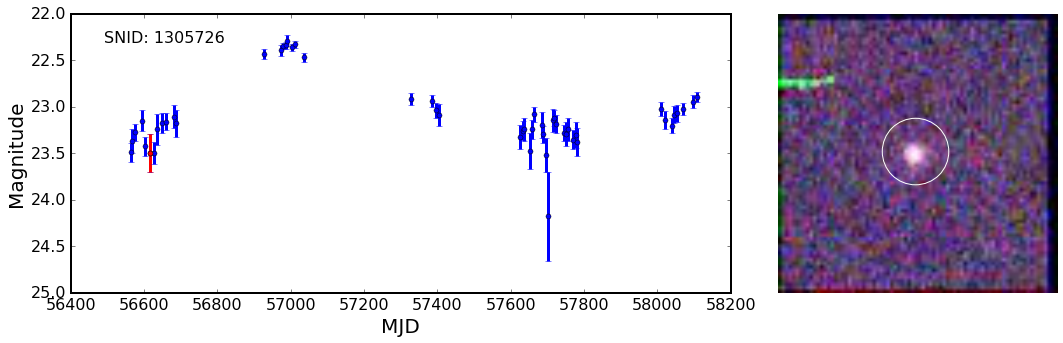

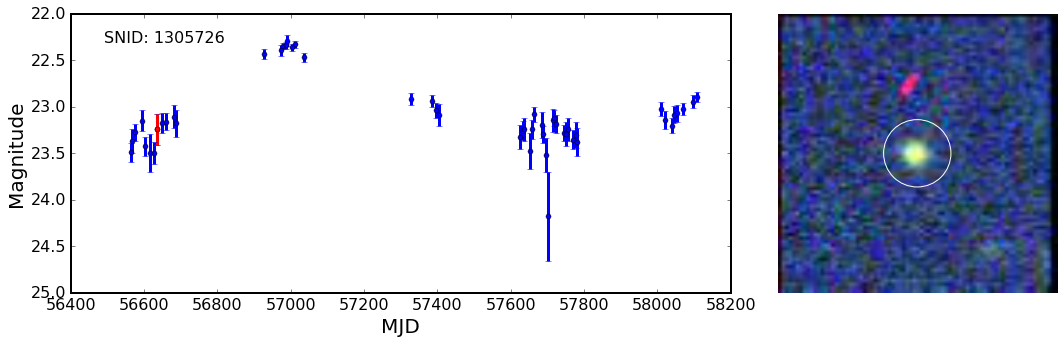

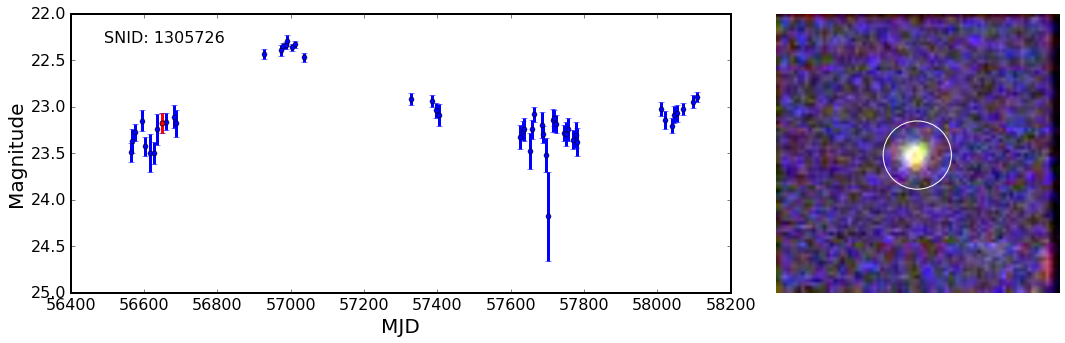

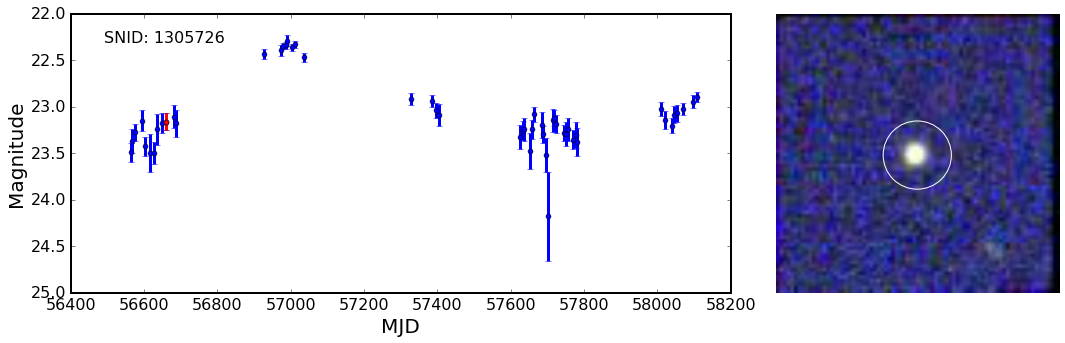

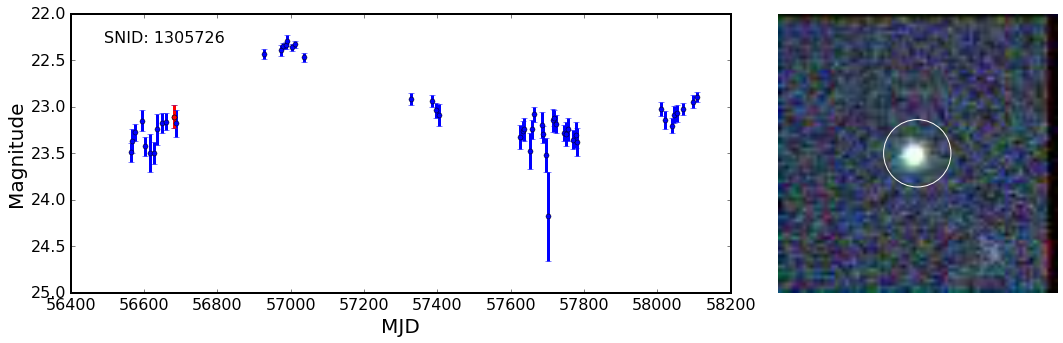

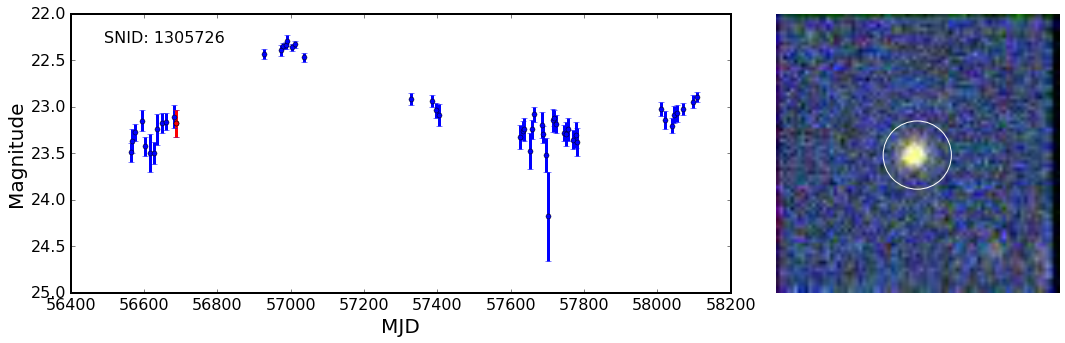

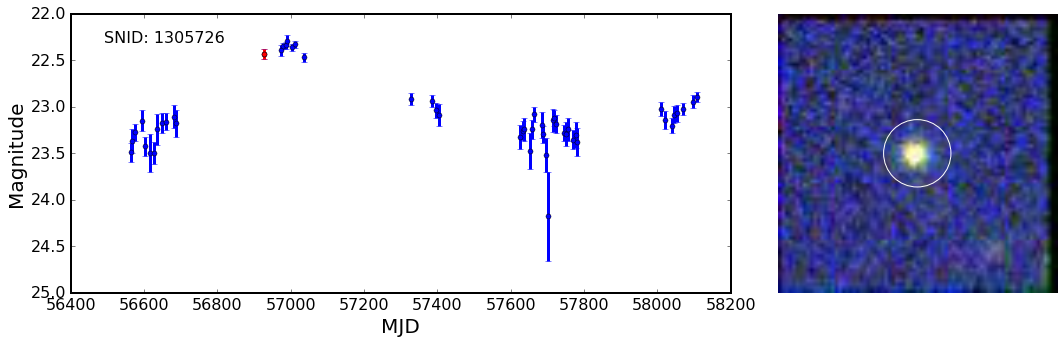

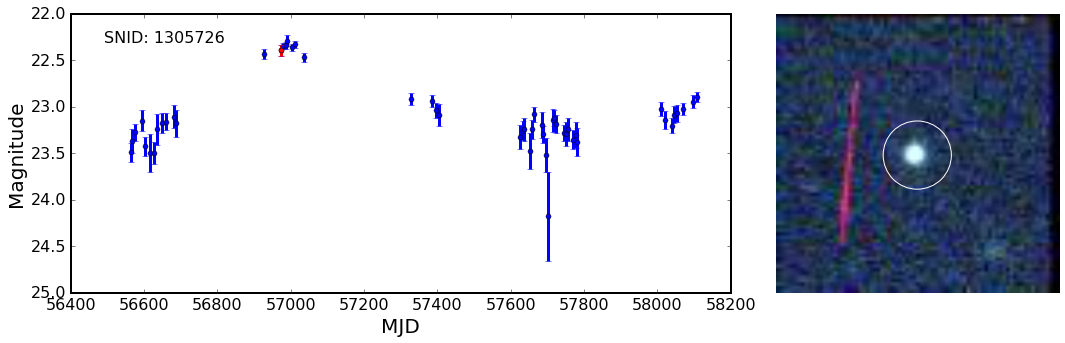

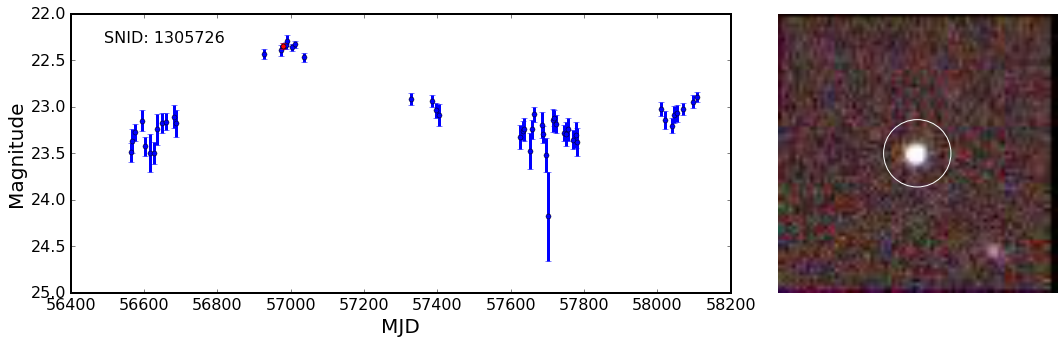

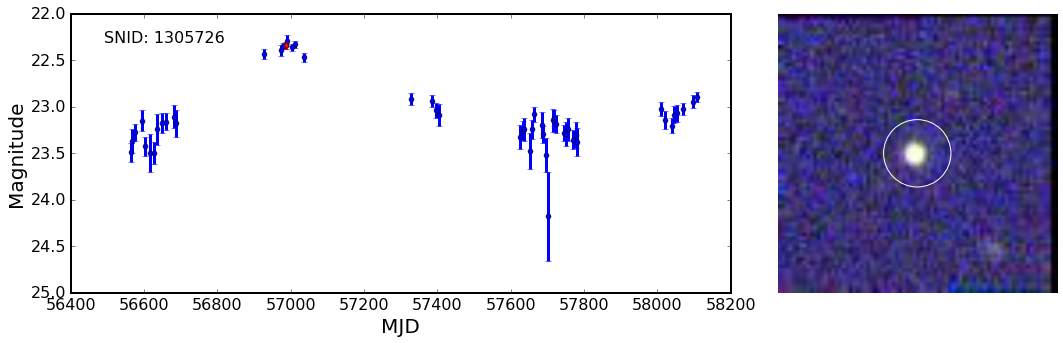

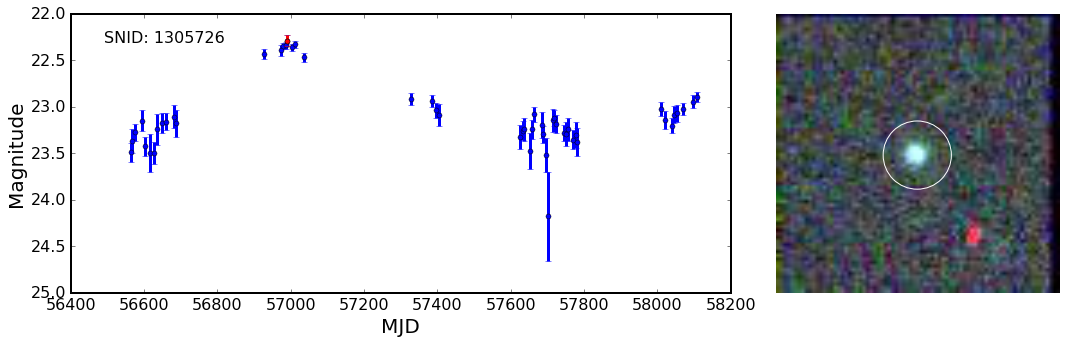

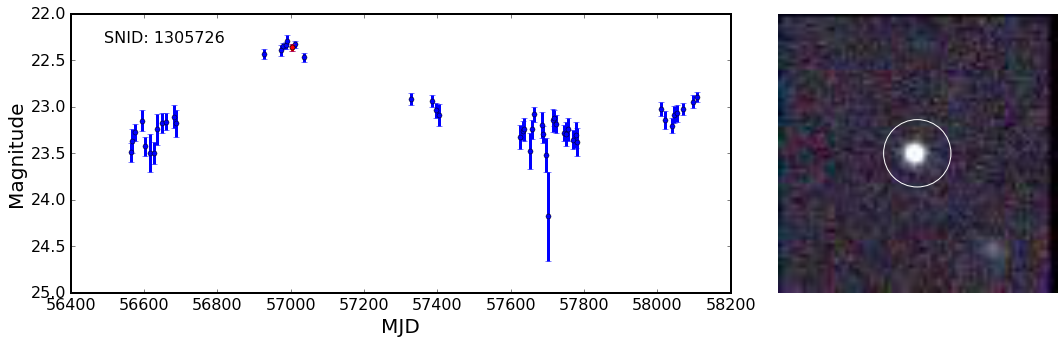

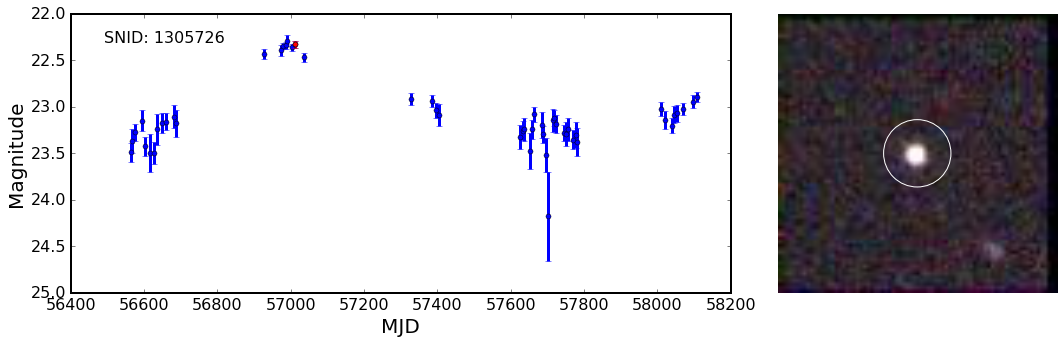

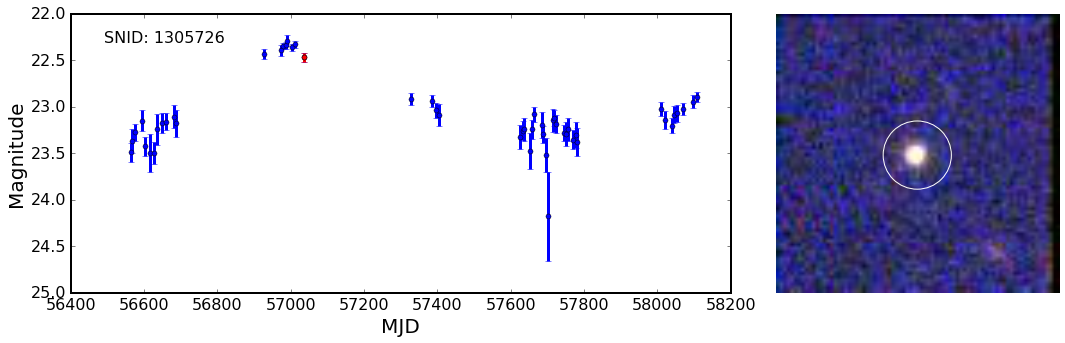

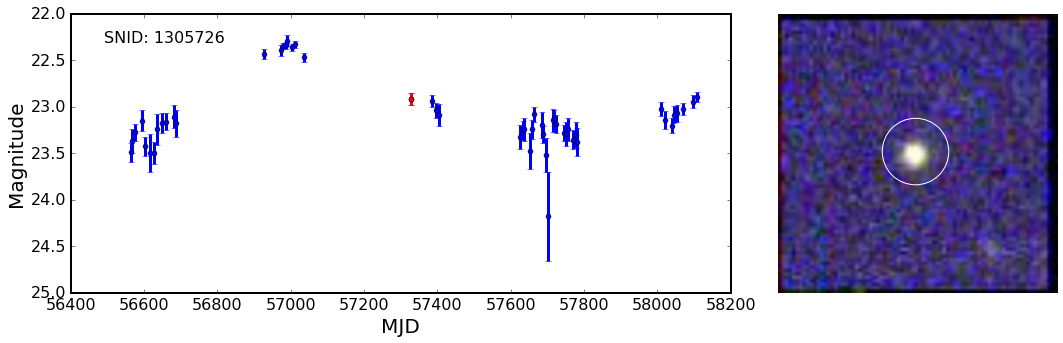

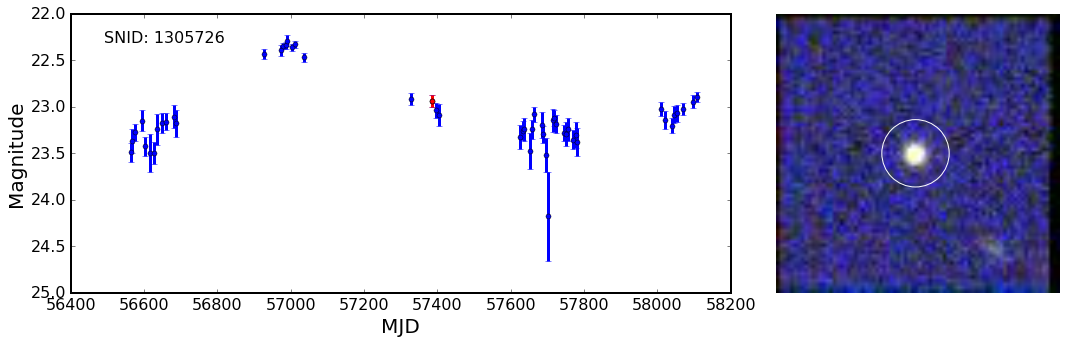

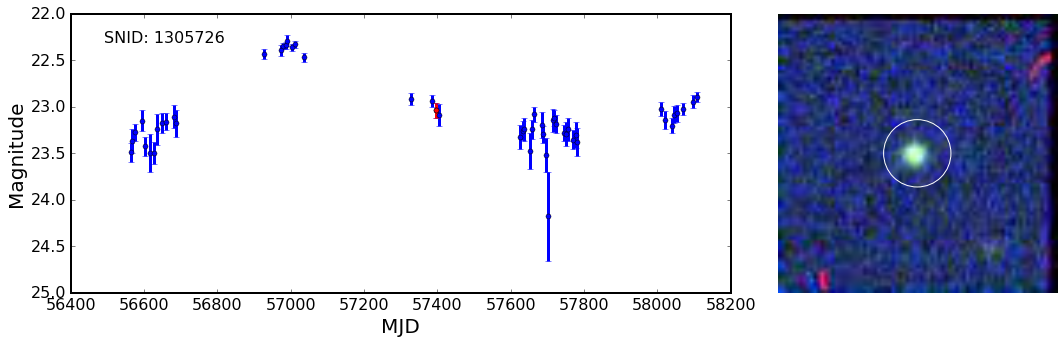

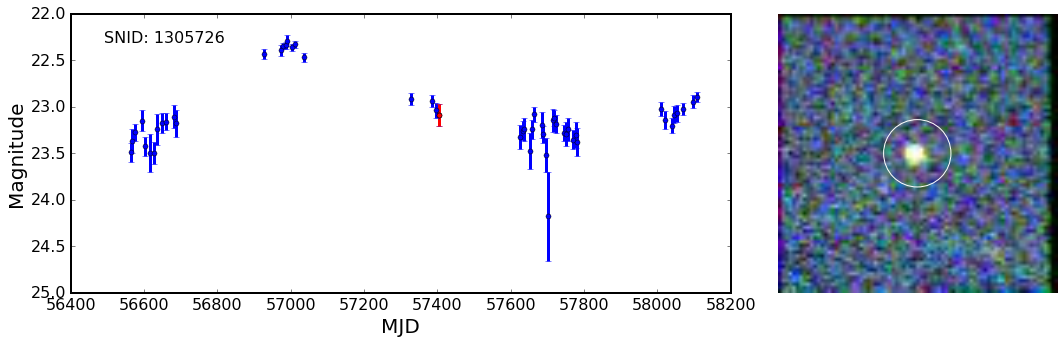

In [207]:
#41.80371,-1.185075 (1258135) z=0.4852 
#des_real_01258135.dat
#convert *.pdf -delay 100 -resize 50% -loop 0 curve.gif
#convert *.pdf -delay 100 -loop 0 curve.gif
name='1305726' #'1258135'
cat_result=fits.open('../ALL_31642_lite.fits')
cat=cat_result[1].data
idx=np.where(cat['SNID'] == name,True,False)
file='../data/all_real_lc/des_real_0'+name+'.dat'
data=np.genfromtxt(file,skip_header =70,usecols=(1,2,3,4,5,6),
                  dtype=(float,'S32','S32',float,float,int),
                  names=['MJD','FLT', 'FIELD', 'FLUXCAL','ERR','flag']) 

host_mag_g=cat['host_g'][idx]
ff=10**((host_mag_g-27.5)/-2.5) # mag to flux

ind=np.where( (data['FLT'] == 'g' ) & ( abs(data['ERR']/data['FLUXCAL']) <0.3),True,False)
#print np.sum(ind)
mag=-2.5*np.log10((data['FLUXCAL'][ind])+ff)+27.5
magerr=-2.5*np.log10((data['FLUXCAL'][ind])+data['ERR'][ind]+ff)+27.5-mag
mjd=data['MJD'][ind]




for ii in range(len(mjd)):
    t = Time(mjd[ii], format='mjd', scale='utc')
    dd= str(t.datetime.year)+str(t.datetime.month).zfill(2)+str(t.datetime.day-1).zfill(2)
    if os.path.exists('./gif_figure/3color/'+dd+'_RGB.jpg') is True:

        fig=plt.figure(figsize=(18,5))
        ax=plt.subplot(1,6,(1,4))
        plt.style.use('my')
        plt.errorbar(mjd,mag,yerr=magerr,fmt='o',ms=5)

        plt.gca().invert_yaxis()
        plt.xlabel('MJD')
        plt.ylabel('Magnitude')

        plt.text(0.05,0.9,'SNID: '+name,transform=ax.transAxes,fontsize=16)
        plt.errorbar(mjd[ii],mag[ii],yerr=magerr[ii],fmt='o',ms=5,color='r')

        ax=plt.subplot(1,6,(5,6))

        try:
            plt.imshow(mpimg.imread('./gif_figure/3color/'+dd+'_RGB.jpg'))
            circle1 = plt.Circle((39,39), 2.5/0.2622,fill=False,color='white')
            ax.add_artist(circle1)
            plt.axis('off')
            fig.savefig('./gif_figure/1/'+str(round(mjd[ii]))+'.pdf')
            plt.cls()
        except:
            continue
